# Regression  
Regression is when you try and predict an outcome of a continuous value. I know the name is terrible but it is what it is and we can't change it now. Here is the actual [tutorial](https://www.tensorflow.org/tutorials/keras/basic_regression)

The next TensorFlow tutorial is using the [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset to predict the fuel efficiency of cars.

In [26]:
#Imports
from __future__ import absolute_import, division, print_function

import seaborn as sns #Installed with pip install seaborn
import matplotlib.pyplot as plt

import pathlib
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.12.0


**Auto MPG Dataset**  
We need to download the dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/). I have used this dataset a few times during grad school. It was mostly used for my data visualization class since it has mutliple dimensions that can show some pretty neat graphs.

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data","https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'C:\\Users\\nurl_\\.keras\\datasets\\auto-mpg.data'

**Pandas**  
We will use Pandas to manipulate the data. Coming from a .NET background this library blew my mind.

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


**Cleaning the Data**  
There are a few things that are done when first looking at data. One thing to note if you are cleaning data, make sure you are not missing something because you are removing rows. I was working with some custom IMDB data and cleaning out records that had NA in them removed a lot of valuable information. This is especially true when you are working with survey data.

In [6]:
#Check NA values
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
#Drop rows
dataset = dataset.dropna()

**One-hot Encoding**  
When a column is really a category you can do something called one-hot encoding. Basically, you convert a category into a binary representation of it.

In [10]:
#Convert origin to one-hot.
origin = dataset.pop('Origin')
origin.tail()

393    1
394    2
395    1
396    1
397    1
Name: Origin, dtype: int64

In [11]:
#Create new columns based on the Origin value
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


**Split the data (train/test)**  
We need to split the data so that we can determine if our training was successful. We are going to do 80/20

In [19]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print('Training Size: %s' % (train_dataset.shape[0]))
print('Testing Size: %s' % (test_dataset.shape[0]))

Training Size: 314
Testing Size: 78


**Inspecting the data**  
We are going to use the Seaborn library and do a pairwise plot to compare the 4 columns we are looking at.

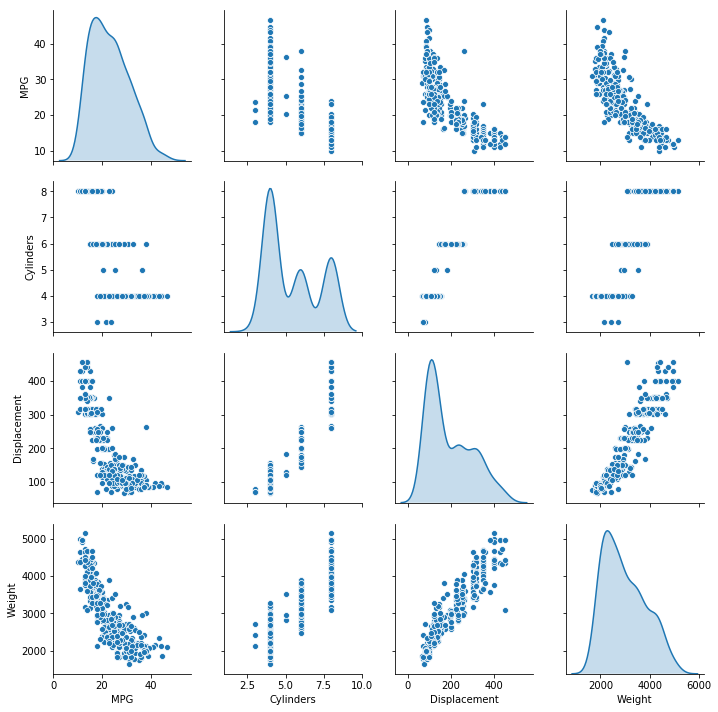

In [28]:
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Weight']],diag_kind="kde")
plt.show()

In [29]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


**Remove 'Answer' from Data**  
We are going to remove the MPG column from the dataset. Think of the remaining data as your homework and the MPG column as your answer. The 'answer' column is called the label.

In [30]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

**Normalize the data**  
Looking at the stats from above you can see there is a wide range of values. We need to normalize those. This makes convergence easier and training easier.

In [31]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

**Building the Model**  
We are going to start building the model. We are going to use the *Sequential* model with 2 densely connected hidden layers. The output layer will return a single, continuous value.

In [32]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.train.RMSPropOptimizer(0.001)
    
    model.compile(loss='mse',
             optimizer=optimizer,
             metrics=['mae','mse'])
    
    return model

In [34]:
model = build_model()

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [36]:
#Testing the model
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.36919343],
       [0.1719961 ],
       [0.1875425 ],
       [0.3642504 ],
       [0.08216984],
       [0.25062817],
       [0.15092151],
       [0.1228369 ],
       [0.20097859],
       [0.0026115 ]], dtype=float32)

**Train the Model**  
We are now going to train the mode using 1000 epochs.  
Take note of the *validation_split*. We are using 20% to validate during training.

In [38]:
#Display training progress by printing a single dot
class PrintDoc(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose = 0,
    callbacks=[PrintDoc()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [40]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,10.687391,2.443462,10.687391,2.212690,0.990048,2.212690,995
996,10.942385,2.504808,10.942385,2.301579,1.036248,2.301579,996
997,10.433399,2.352387,10.433399,2.311342,1.020491,2.311342,997
998,11.156307,2.504645,11.156307,2.280385,0.992756,2.280385,998
999,10.672542,2.398543,10.672542,2.281119,0.977800,2.281119,999


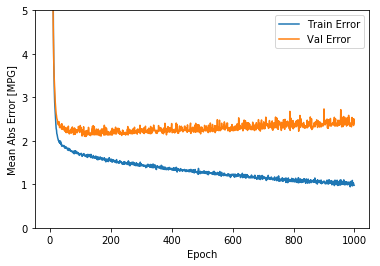

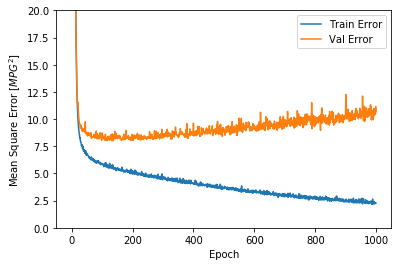

In [44]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,5])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,20])
  plt.show()

plot_history(history)

**Initial Results**  
The graphs show very little imporovement after the first 100 epochs. We can update the *fit* method (which I have never done so this is new to me!) to automatically stop training when the validation score doesn't improve.


....................................................................................................
...............................................................

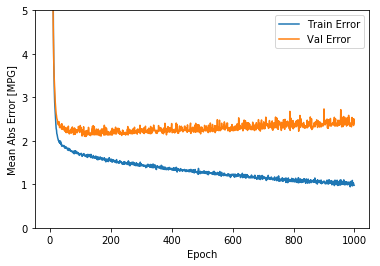

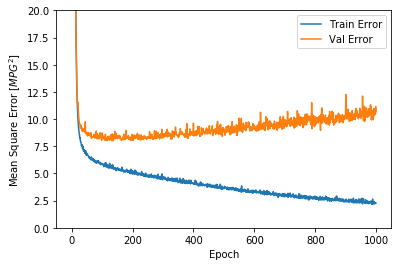

In [46]:
model = build_model()

#The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose = 0,
                   callbacks=[early_stop, PrintDoc()])

plot_history(history)

**Results**  
The top graph shows that we are within 2 MPGs in our training. If that passes your predetermined limit then we are ok to move on. If that isn't, you will need to go back in and tweak your model. Since this is just a learning problem we are going to move on.

**Testing**  
We are now going to see how our model does with the test set.

In [47]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  2.09 MPG


**Making Predictions**

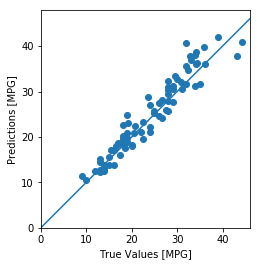

In [48]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100,100], [-100,100])
plt.show()

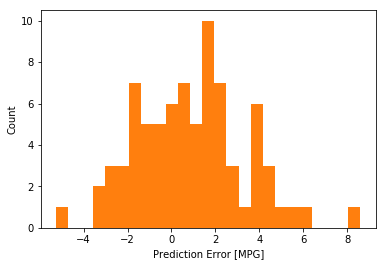

In [50]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
plt.show()

**Conclusion**  
We covered a few new techniques to handle a regression problem.
* Mean Square Error (MSE) is a common loss function used for regression problems
* Mean Absolute Error (MAE) is an evaluation metric used for regression problems
* Scaling is used when your data values vary widely
* A smaller network is used when you don't have a lot of data. The larger the network (more layers or neurons) require more data
* Overfitting is avoided by using early stopping

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.